In [1]:
library(igraph)
library(neat)
library(utils)
library(reshape2)
library(ggplot2)
library(pheatmap)
library(viridis)
library(RPostgreSQL)
library(stringr)
library(UpSetR)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: viridisLite
Loading required package: DBI


In [2]:
col=read.delim("../subnetwork_colours.csv",sep=",",stringsAsFactors=FALSE)
col2=as.character(col$colour)
names(col2)=col$network
col2

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI 
"#AD5882" "#C66764" "#449B76"

In [3]:
con = dbConnect(PostgreSQL(),dbname = 'dl', 
                 host = 'pgsbdb1',
                 port = 5432)

In [4]:
A=dbGetQuery(con,"select * from physcogrn.gene_name") 
A=A[,-c(2:3)]
str(A)
head(A)

'data.frame':	35752 obs. of  4 variables:
 $ geneid     : chr  "Pp3c15_11610.mRNA" "Pp3c19_8700.mRNA" "Pp3c4_2680.mRNA" "Pp3c16_13260.mRNA" ...
 $ reg_class  : chr  "TR" "TF" "TF" "TF" ...
 $ name       : chr  "GNAT" "tify" "AP2/EREBP" "AP2/EREBP" ...
 $ description: chr  "PTHR24055:SF10 - MITOGEN-ACTIVATED PROTEIN KINASE 3 (1 of 1)" "PTHR33077:SF8 - PROTEIN TIFY 8 (1 of 2)" "PF00847 - AP2 domain (AP2)  (1 of 150)" "PF00847 - AP2 domain (AP2)  (1 of 150)" ...


geneid,reg_class,name,description
Pp3c15_11610.mRNA,TR,GNAT,PTHR24055:SF10 - MITOGEN-ACTIVATED PROTEIN KINASE 3 (1 of 1)
Pp3c19_8700.mRNA,TF,tify,PTHR33077:SF8 - PROTEIN TIFY 8 (1 of 2)
Pp3c4_2680.mRNA,TF,AP2/EREBP,PF00847 - AP2 domain (AP2) (1 of 150)
Pp3c16_13260.mRNA,TF,AP2/EREBP,PF00847 - AP2 domain (AP2) (1 of 150)
Pp3c9_11330.mRNA,TF,tify,PTHR33077:SF13 - PROTEIN TIFY 10A-RELATED (1 of 10)
Pp3c14_14900.mRNA,TF,"ppmc6,PPMC6","K09264 - MADS-box transcription factor, plant (K09264) (1 of 2)"


In [5]:
path="../../ontology_enrichment/input/profiles_sets/"
profiles=sapply(gsub("\\.set","",list.files(path=path,pattern="*.set")),function(n) {
    f=paste(path,paste(n,"set",sep="."),sep="/")
    read.table(f,sep="\t",header=FALSE,stringsAsFactors=FALSE)[,1]
})
str(profiles)
names(profiles)=c("repressor target","activator target")
str(profiles)
profiles=stack(profiles)
names(profiles)=c("geneid","pattern")
profiles$pattern=factor(as.character(profiles$pattern),levels=c("not deregulated","TF with deregulated target","repressor target","activator target"))
str(profiles)
table(profiles$pattern)
pp=profiles


List of 2
 $ downDEK1_upOEX: chr [1:2639] "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ upDEK1_downOEX: chr [1:2445] "Pp3c1_10400.mRNA" "Pp3c1_10760.mRNA" "Pp3c1_10830.mRNA" "Pp3c1_12715.mRNA" ...
List of 2
 $ repressor target: chr [1:2639] "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ activator target: chr [1:2445] "Pp3c1_10400.mRNA" "Pp3c1_10760.mRNA" "Pp3c1_10830.mRNA" "Pp3c1_12715.mRNA" ...
'data.frame':	5084 obs. of  2 variables:
 $ geneid : chr  "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ pattern: Factor w/ 4 levels "not deregulated",..: 3 3 3 3 3 3 3 3 3 3 ...



           not deregulated TF with deregulated target 
                         0                          0 
          repressor target           activator target 
                      2639                       2445 

In [6]:
d=read.delim(gzfile("../GENIE3.top10_target_ranks.ranked_regulator_target_interactions.with_communities.correlations_and_directionality.tsv.gz"),sep="\t",stringsAsFactors=FALSE)
dd=d
d=subset(d,community %in% as.character(as.roman(1:11)))
dd=subset(dd,community %in% as.character(as.roman(1:11)) | community == 0)
head(d)

regulatoryGene,targetGene,full_cor,full_reg,our_cor,our_reg,weight,regulator_rank,target_rank,mutual_rank,regulator_community,target_community,community
Pp3c17_930.mRNA,Pp3s340_10.mRNA,0.1304851,+,1.874270e-15,+,0.06778052,1,1,1,I,I,I
Pp3c1_27430.pre_miRNA,Pp3c15_12100.mRNA,0.5589259,+,6.662628e-01,+,0.06724901,1,1,1,II,II,II
Pp3c17_17550.mRNA,Pp3c23_130.mRNA,0.8464697,+,8.916522e-01,+,0.06646932,1,1,1,II,II,II
Pp3c17_18920.pre_miRNA,Pp3s32_420.mRNA,1.0000000,+,1.000000e+00,+,0.06632740,1,1,1,III,III,III
Pp3c15_549.mRNA,Pp3c4_24040.mRNA,1.0000000,+,1.000000e+00,+,0.06400505,1,1,1,IV,IV,IV
Pp3c4_3072.pre_miRNA,Pp3c22_1240.mRNA,0.9517601,+,9.665704e-01,+,0.06353888,1,1,1,II,II,II


In [7]:
n=read.delim("../GENIE3.top10_target_ranks.communities_PLM.with_node_centralities.csv",sep=";",stringsAsFactors=FALSE)
n=subset(n,community %in% as.character(as.roman(1:11)))
head(n)

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank
Pp3c27_3080.mRNA,I,109,0,0.00000000,0.9977499,1
Pp3c11_23290.mRNA,I,552,3190,0.05359921,0.9971070,2
Pp3c7_2300.mRNA,I,505,7529,0.02518149,0.9971070,3
Pp3c17_23620.mRNA,I,490,1988,0.05419710,0.9971070,4
Pp3c16_13280.mRNA,I,485,9982,0.05634423,0.9971070,5
Pp3c15_11610.mRNA,I,461,3734,0.04049888,0.9971070,6


In [8]:
G=graph_from_data_frame(d,directed = TRUE,vertices = n)

In [9]:
com=sapply(as.character(as.roman(1:11)),function(i) n[n$community==i, "geneid"])
str(com)

List of 11
 $ I   : chr [1:3112] "Pp3c27_3080.mRNA" "Pp3c11_23290.mRNA" "Pp3c7_2300.mRNA" "Pp3c17_23620.mRNA" ...
 $ II  : chr [1:4418] "Pp3c15_24790.mRNA" "Pp3c4_14601.pre_miRNA" "Pp3c22_13060.mRNA" "Pp3c9_13190.mRNA" ...
 $ III : chr [1:1705] "Pp3c13_10800.mRNA" "Pp3c22_11080.mRNA" "Pp3c16_9970.mRNA" "Pp3c8_250.mRNA" ...
 $ IV  : chr [1:2728] "Pp3c19_7560.mRNA" "Pp3c19_9880.mRNA" "Pp3c20_7710.mRNA" "Pp3c6_29020.mRNA" ...
 $ V   : chr [1:3435] "Pp3c22_2330.mRNA" "Pp3c5_12740.mRNA" "Pp3c8_6890.mRNA" "Pp3c7_25430.mRNA" ...
 $ VI  : chr [1:1849] "Pp3c16_20970.mRNA" "Pp3c1_32480.mRNA" "Pp3c10_13060.mRNA" "Pp3c4_25130.mRNA" ...
 $ VII : chr [1:3851] "Pp3c2_35433.mRNA" "Pp3c7_24670.mRNA" "Pp3c15_14600.mRNA" "Pp3c9_14240.mRNA" ...
 $ VIII: chr [1:3662] "Pp3c10_2910.mRNA" "Pp3c1_4600.mRNA" "Pp3c14_4440.mRNA" "Pp3c2_15500.mRNA" ...
 $ IX  : chr [1:6167] "Pp3c13_8290.mRNA" "Pp3c5_21130.mRNA" "Pp3c3_31770.mRNA" "Pp3c3_17380.mRNA" ...
 $ X   : chr [1:2403] "Pp3c1_15290.mRNA" "Pp3c16_15450.mRNA" "

In [10]:
neat=read.delim("../NEAT_subnetwork_enrichment.profiles.tsv",sep="\t",stringsAsFactors=TRUE)
head(neat)
levels(neat$A)
levels(neat$A)=list("repressor target"="downDEK1_upOEX", "activator target"="upDEK1_downOEX")
levels(neat$A)
table(neat$conclusion,neat$bonferroni<0.01)

A,B,nab,expected_nab,pvalue,conclusion,fdr,bonferroni
downDEK1_upOEX,IX,7988,5569.140,6.857806e-274,Overenrichment,2.514529e-273,1.508717e-272
downDEK1_upOEX,VIII,2034,3411.840,6.203299e-169,Underenrichment,1.137271e-168,1.364726e-167
downDEK1_upOEX,V,8070,3398.263,0.000000e+00,Overenrichment,0.000000e+00,0.000000e+00
downDEK1_upOEX,XI,951,1982.179,9.680158e-165,Underenrichment,1.638181e-164,2.129635e-163
downDEK1_upOEX,I,1672,2934.464,1.751379e-164,Underenrichment,2.752167e-164,3.853034e-163
downDEK1_upOEX,II,3165,3528.176,8.606751e-12,Underenrichment,9.016597e-12,1.893485e-10


[1] "downDEK1_upOEX" "upDEK1_downOEX"

[1] "repressor target" "activator target"

                 
                  FALSE TRUE
  No enrichment       1    0
  Overenrichment      0    6
  Underenrichment     0   15

In [11]:
nrow(d)
D=droplevels(subset(dd, targetGene %in% profiles$geneid)) # allowing also inter subnetwork links 
nrow(D)

nrow(n)
NN=droplevels(subset(n, geneid %in% D$regulatoryGene))
nrow(NN)

[1] 215035

[1] 50840

[1] 35639

[1] 1349

In [12]:
nrow(profiles)
nrow(n)
profiles= rbind(profiles,data.frame(geneid=setdiff(n$geneid,profiles$geneid),pattern="not deregulated"))
nrow(profiles)
table(profiles$pattern)

[1] 5084

[1] 35639

[1] 35639


           not deregulated TF with deregulated target 
                     30555                          0 
          repressor target           activator target 
                      2639                       2445 

In [13]:
N=merge(n,profiles,by="geneid")
nrow(N)
head(N)
table(N$pattern)

[1] 35639

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,pattern
Pp3c1_100.mRNA,XI,0,0,0.0014150125,0,1646,not deregulated
Pp3c1_1000.mRNA,VIII,0,0,0.0218658786,0,801,not deregulated
Pp3c1_10000.mRNA,I,0,0,0.0075954511,0,1736,not deregulated
Pp3c1_10010.mRNA,VIII,0,0,0.0156725382,0,1155,not deregulated
Pp3c1_10020.seryl_tRNA,II,0,0,0.0001972498,0,3771,not deregulated
Pp3c1_10040.mRNA,IX,0,0,0.0028652419,0,3978,not deregulated



           not deregulated TF with deregulated target 
                     30555                          0 
          repressor target           activator target 
                      2639                       2445 

In [14]:
N=merge(N,A,by="geneid")
nrow(N)
N=N[!duplicated(N$geneid),]
nrow(N)
head(N)

[1] 35685

[1] 35639

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,pattern,reg_class,name,description
Pp3c1_100.mRNA,XI,0,0,0.0014150125,0,1646,not deregulated,NA,"PHYPA_000006, Gip1-1",probable glycerol uptake facilitator protein
Pp3c1_1000.mRNA,VIII,0,0,0.0218658786,0,801,not deregulated,NA,NA,NA
Pp3c1_10000.mRNA,I,0,0,0.0075954511,0,1736,not deregulated,NA,NA,K00021 - hydroxymethylglutaryl-CoA reductase (NADPH) (HMGCR) (1 of 3)
Pp3c1_10010.mRNA,VIII,0,0,0.0156725382,0,1155,not deregulated,NA,NA,"PTHR11451:SF41 - GLUTAMATE--TRNA LIGASE, MITOCHONDRIAL-RELATED (1 of 1)"
Pp3c1_10020.seryl_tRNA,II,0,0,0.0001972498,0,3771,not deregulated,NA,NA,NA
Pp3c1_10040.mRNA,IX,0,0,0.0028652419,0,3978,not deregulated,NA,NA,K14846 - ribosome production factor 1 (RPF1) (1 of 1)


In [15]:
table(N$pattern,N$reg_class)

                            
                             miRNA  PT putative_miRNA  TF  TR
  not deregulated              166  58             46 803 319
  TF with deregulated target     0   0              0   0   0
  repressor target               1   8              0  85  41
  activator target               1  10              0  88  43

In [16]:
N$pattern[N$pattern=="not deregulated" & N$geneid %in% NN$geneid & N$reg_class=="TF"]="TF with deregulated target"
table(N$pattern,N$reg_class)

                            
                             miRNA  PT putative_miRNA  TF  TR
  not deregulated              166  58             46  89 319
  TF with deregulated target     0   0              0 714   0
  repressor target               1   8              0  85  41
  activator target               1  10              0  88  43

In [17]:
round(prop.table(table( N$pattern, N$community),1)*100)
table( N$pattern, N$community)

                            
                              I II III IV IX  V VI VII VIII  X XI
  not deregulated             9 12   5  9 15  9  6  11   10  7  7
  TF with deregulated target 14 20   8  6 14  5  4   6    9  8  7
  repressor target            8 10   1  1 31 21  2   8   10  3  4
  activator target            5 13   2  2 29 10  2   8   13 12  5

                            
                                I   II  III   IV   IX    V   VI  VII VIII    X
  not deregulated            2688 3713 1572 2608 4529 2599 1710 3397 3026 1970
  TF with deregulated target   97  142   54   40   99   38   25   45   63   60
  repressor target            204  257   33   37  825  558   53  223  261   83
  activator target            123  306   46   43  714  240   61  186  312  290
                            
                               XI
  not deregulated            2029
  TF with deregulated target   51
  repressor target            105
  activator target            124

In [18]:
pp=lapply(levels(N$pattern)[-1],function(x) {
    unique(subset(N,pattern==x)$geneid)})
names(pp)=levels(N$pattern)[-1]
str(pp)

List of 3
 $ TF with deregulated target: chr [1:714] "Pp3c1_12940.mRNA" "Pp3c1_14230.mRNA" "Pp3c1_14480.mRNA" "Pp3c1_15290.mRNA" ...
 $ repressor target          : chr [1:2639] "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ activator target          : chr [1:2445] "Pp3c1_10400.mRNA" "Pp3c1_10760.mRNA" "Pp3c1_10830.mRNA" "Pp3c1_12715.mRNA" ...


In [19]:
tc=read.delim("../../sleuth//comp.WT_phases/dge.tsv.gz",sep="\t",stringsAsFactors=FALSE)
nrow(tc)
tc=na.omit(tc)
nrow(tc)
head(tc)

[1] 21752

[1] 21752

target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
Pp3s49_30.mRNA,mRNA,mRNA,2.977600e-12,6.476875e-08,48.70333,177.5279,1,4.010792,13.65600,⋯,1.008618e-84,2.193946e-80,7.317238,0.3751596,4.010792,13.65600,0.006823643,0.4455701,0.10997257,0.4455701
Pp3c7_9420.mRNA,mRNA,mRNA,2.320054e-08,3.881986e-06,31.20635,186.8794,1,4.540091,14.37534,⋯,1.211662e-23,2.214796e-21,7.206672,0.7190361,4.540091,14.37534,0.012675319,1.6491517,0.07447159,1.6491517
Pp3c26_14380.mRNA,mRNA,mRNA,2.602332e-10,4.354302e-07,39.95236,149.8390,1,3.568815,11.52608,⋯,5.613964e-45,1.110136e-41,6.629719,0.4711154,3.568815,11.52608,0.002858010,0.7105517,0.14794491,0.7105517
Pp3c14_20550.mRNA,mRNA,mRNA,4.388513e-08,5.648458e-06,29.96970,145.4578,1,4.125416,11.18906,⋯,1.475792e-21,2.018958e-19,6.322859,0.6630092,4.125416,11.18906,0.079183880,1.3337556,0.10136846,1.3337556
Pp3c16_3130.mRNA,mRNA,mRNA,1.112431e-07,9.757097e-06,28.16774,146.2688,1,3.651705,11.25145,⋯,7.944066e-19,7.480490e-17,6.282743,0.7090490,3.651705,11.25145,0.070836783,1.5451467,0.14025237,1.5451467
Pp3c6_15620.mRNA,mRNA,mRNA,2.525141e-08,4.099020e-06,31.04193,136.7621,1,5.413097,10.52016,⋯,2.351254e-23,4.124554e-21,6.160701,0.6187327,5.413097,10.52016,0.095882724,1.1346428,0.03419986,1.1346428


In [20]:
table(tc$qval.lrt<0.1 & tc$qval.wt<0.1)


FALSE  TRUE 
11380 10372 

In [21]:
tc=subset(tc,qval.lrt<0.1 & qval.wt<0.1)
nrow(tc)

[1] 10372

In [22]:
pp[["WT 3-5 days"]]=subset(tc,b<0)$target_id
pp[["WT 9-14 days"]]=subset(tc,b>0)$target_id

In [23]:
str(pp)

List of 5
 $ TF with deregulated target: chr [1:714] "Pp3c1_12940.mRNA" "Pp3c1_14230.mRNA" "Pp3c1_14480.mRNA" "Pp3c1_15290.mRNA" ...
 $ repressor target          : chr [1:2639] "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ activator target          : chr [1:2445] "Pp3c1_10400.mRNA" "Pp3c1_10760.mRNA" "Pp3c1_10830.mRNA" "Pp3c1_12715.mRNA" ...
 $ WT 3-5 days               : chr [1:4744] "Pp3c18_20030.mRNA" "Pp3c3_31560.mRNA" "Pp3c1_15390.mRNA" "Pp3c16_4180.mRNA" ...
 $ WT 9-14 days              : chr [1:5628] "Pp3s49_30.mRNA" "Pp3c7_9420.mRNA" "Pp3c26_14380.mRNA" "Pp3c14_20550.mRNA" ...


In [24]:
test.pr = neat(alist = pp, blist = com, network = G, nettype = 'undirected', nodes = n$geneid, alpha = 0.05) 

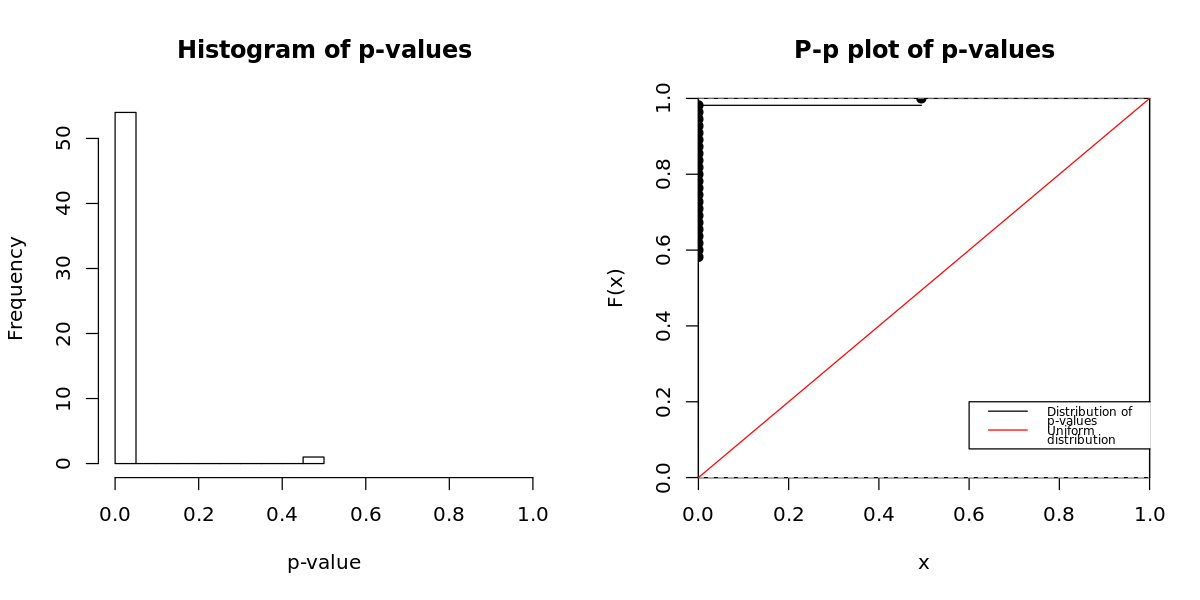

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
plot(test.pr)

In [26]:
test.pr$fdr=p.adjust(test.pr$pvalue,method="fdr")
test.pr$bonferroni=p.adjust(test.pr$pvalue,method="bonferroni")
table(test.pr$conclusion,test.pr$fdr<0.01,test.pr$bonferroni<0.01)

, ,  = FALSE

                 
                  FALSE TRUE
  No enrichment       1    0
  Overenrichment      0    0
  Underenrichment     0    0

, ,  = TRUE

                 
                  FALSE TRUE
  No enrichment       0    0
  Overenrichment      0   17
  Underenrichment     0   37


In [27]:
Test.pr=subset(test.pr[order(-test.pr$nab),], conclusion=="Overenrichment" & fdr<0.01)
table(Test.pr$A,Test.pr$B)

                            
                             I II III IV IX V VI VII VIII X XI
  activator target           0  1   0  0  1 0  0   0    1 1  0
  repressor target           0  0   0  0  1 1  0   0    0 0  0
  TF with deregulated target 1  1   1  0  0 0  0   0    1 1  1
  WT 3-5 days                0  0   0  0  0 1  0   0    1 0  0
  WT 9-14 days               0  1   0  0  0 0  0   0    0 1  1

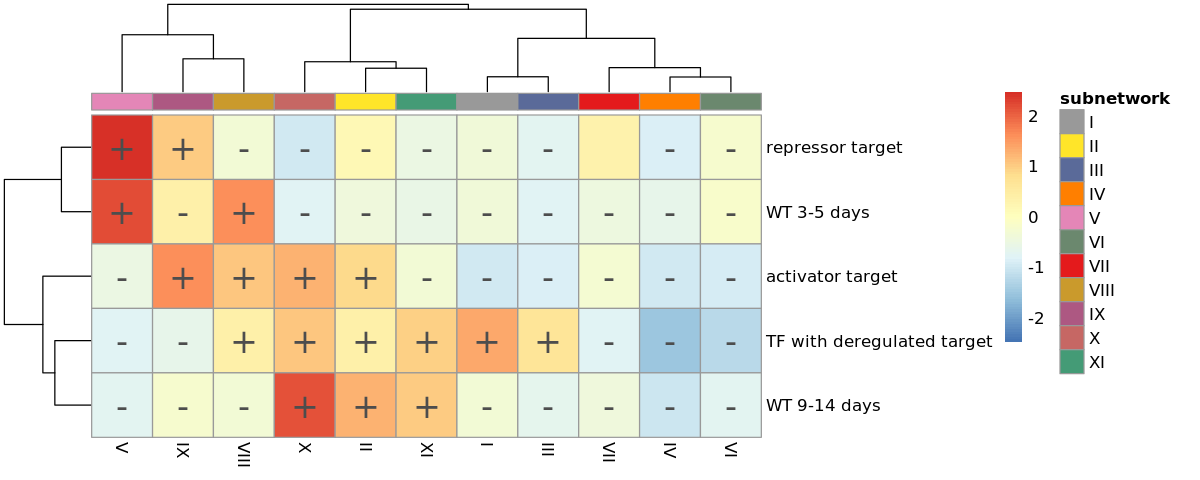

In [28]:
x=test.pr
x$var=x$nab/x$expected_nab
X=dcast(x,A~B,value.var="var")
row.names(X)=gsub("_"," & ",X[,1])
X=X[,-1]
x$var2=ifelse(x$fdr<0.01,ifelse(x$conclusion=="Overenrichment","+","-"),"")
XX=dcast(x,A~B,value.var="var2")
row.names(XX)=gsub("_"," & ",XX[,1])
XX=XX[,-1]
net=data.frame(subnetwork=as.character(col$network))
row.names(net)=col$network
options(repr.plot.width=10, repr.plot.height=4)

pheatmap(mat=X,scale="row",
         annotation_col=net,
         annotation_names_row = FALSE, annotation_names_col = FALSE,
         annotation_colors=list(subnetwork=col2),
         annotation_legend=TRUE,
         clustering_method="ward.D2",
         display_numbers=XX,
         fontsize_number=20
        )

In [29]:
write.table(test.pr,file="NEAT_subnetwork_enrichment.patterns.tsv",sep="\t",row.names=FALSE,col.names=TRUE,quote=FALSE)

In [30]:
x=test.pr
x$var=x$nab/x$expected_nab
X=dcast(x,A~B,value.var="var")
row.names(X)=gsub("_"," & ",X[,1])
X=X[,-1]
x$var2=ifelse(x$fdr<0.01,ifelse(x$conclusion=="Overenrichment","+","-"),"")
XX=dcast(x,A~B,value.var="var2")
row.names(XX)=gsub("_"," & ",XX[,1])
XX=XX[,-1]
net=data.frame(subnetwork=as.character(col$network))
row.names(net)=col$network
pheatmap(mat=X,scale="row",
         annotation_col=net,
         annotation_names_row = FALSE, annotation_names_col = FALSE,
         annotation_colors=list(subnetwork=col2),
         annotation_legend=TRUE,
         clustering_method="ward.D2",
         display_numbers=XX,
         fontsize_number=20,
         width=10,
         height=4,
         filename="NEAT_subnetwork_enrichment.pattern.pdf"
        )

In [31]:
X=data.frame(prop.table(table( N$pattern, N$community),1)*100)
names(X)=c("pattern","subnetwork","percentage")
nrow(X)
X=merge(X,test.pr,by.x=c("subnetwork","pattern"),by.y=c("B","A"),all.x=TRUE)
nrow(X)
head(X)

XX=data.frame(table(N$pattern, N$community))
names(XX)=c("pattern","subnetwork","genes")
nrow(XX)
nrow(X)
X=merge(X,XX,by=c("pattern","subnetwork"))
head(X)
nrow(X)
table(X$genes>0)
X$genes2=X$genes
soi=as.character(unique(subset(X, pattern %in% c("activator target","repressor target") & conclusion=="Overenrichment" & bonferroni <0.01)$subnetwork))
print(soi)
X$genes[ ! X$subnetwork %in% soi & (is.na(X$conclusion) | X$conclusion!="Overenrichment") ]=NA
X$genes[! X$subnetwork %in% soi & X$pattern=="TF with deregulated target"]=NA
X$genes=ifelse(X$pattern== "TF with deregulated target" &  X$subnetwork %in% soi,X$genes2,X$genes)
X=droplevels(X[X$pattern!= "not deregulated",])
table(X$genes>0)
table(X$pattern,!is.na(X$genes) & X$genes>0)
X$genes=as.character(X$genes)
X$genes=ifelse(!is.na(X$conclusion) & X$subnetwork %in% soi &X$conclusion=="Overenrichment", paste0(X$genes,"*"),X$genes)

[1] 44

[1] 44

subnetwork,pattern,percentage,nab,expected_nab,pvalue,conclusion,fdr,bonferroni
I,not deregulated,9.007741,NA,NA,NA,NA,NA,NA
I,TF with deregulated target,13.585434,15017,9411.015,0.000000e+00,Overenrichment,0.000000e+00,0.000000e+00
I,repressor target,7.730201,1672,2934.464,1.751379e-164,Underenrichment,2.240136e-164,9.632584e-163
I,activator target,5.030675,1094,2924.115,0.000000e+00,Underenrichment,0.000000e+00,0.000000e+00
II,not deregulated,12.442613,NA,NA,NA,NA,NA,NA
II,TF with deregulated target,19.887955,13274,11315.090,2.454027e-108,Overenrichment,2.934162e-108,1.349715e-106


[1] 44

[1] 44

pattern,subnetwork,percentage,nab,expected_nab,pvalue,conclusion,fdr,bonferroni,genes
activator target,I,5.030675,1094,2924.115,0.000000e+00,Underenrichment,0.000000e+00,0.000000e+00,123
activator target,II,12.515337,4350,3515.734,3.291148e-51,Overenrichment,3.481022e-51,1.810131e-49,306
activator target,III,1.881391,680,1620.955,3.956163e-171,Underenrichment,5.439724e-171,2.175890e-169,46
activator target,IV,1.758691,782,2045.297,8.800532e-251,Underenrichment,1.382941e-250,4.840293e-249,43
activator target,IX,29.202454,8730,5549.500,0.000000e+00,Overenrichment,0.000000e+00,0.000000e+00,714
activator target,V,9.815951,1960,3386.279,2.568467e-183,Underenrichment,3.717517e-183,1.412657e-181,240


[1] 44


TRUE 
  44 

[1] "II"   "IX"   "VIII" "X"    "V"   



TRUE 
  15 

                            
                             FALSE TRUE
  TF with deregulated target     6    5
  repressor target               6    5
  activator target               6    5

Warning message:
“Removed 18 rows containing missing values (geom_text).”

Warning message:
“Removed 18 rows containing missing values (geom_text).”

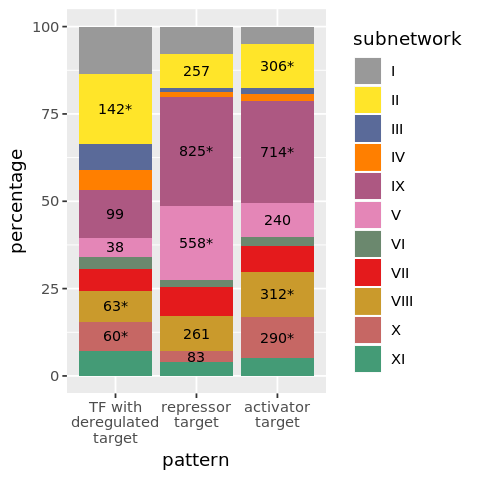

In [32]:
options(repr.plot.width=4, repr.plot.height=4)
GG=ggplot(X,aes(x=pattern,y=percentage,fill=subnetwork,label=genes)) +geom_bar(stat="identity",position="stack") + 
scale_fill_manual(values=col2)+#coord_flip() +
   scale_x_discrete(labels = function(x) str_wrap(x, width = 10)) +
  geom_text(size = 3, position = position_stack(vjust = 0.5))
GG
ggsave(GG,file="Fig2.barplot.pdf",width=4,height=4)

In [33]:
k=read.delim("Fig2.nodes.tsv",stringsAsFactors=FALSE)
k=subset(k,pattern=="not deregulated")
head(k)

,geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,pattern,reg_class,name,description,pattern2,pattern3
15,Pp3c1_12940.mRNA,IX,165,5898,0.001357962,0.9974051,85,not deregulated,TF,C3H,PTHR12547:SF63 - ZINC FINGER CCCH DOMAIN-CONTAINING PROTEIN 37-RELATED (1 of 2),IX,IX
25,Pp3c1_14230.mRNA,II,244,36258,0.081919529,0.9893593,26,not deregulated,TF,AS2/LOB,PF00847 - AP2 domain (AP2) (1 of 150),II,II
30,Pp3c1_15290.mRNA,X,627,3879,0.050173560,1.0000000,1,not deregulated,TF,HD_PLINC,PF04770 - ZF-HD protein dimerisation region (ZF-HD_dimer) (1 of 12),X,X
33,Pp3c1_15410.mRNA,V,387,5174,0.031892393,0.9988352,17,not deregulated,TF,ABI3/VP1,PF02362 - B3 DNA binding domain (B3) (1 of 58),V,V
35,Pp3c1_15560.mRNA,V,549,16223,0.037539501,0.9988352,8,not deregulated,TF,GRAS,PTHR31636:SF16 - SCARECROW-LIKE PROTEIN 28 (1 of 2),V,V
42,Pp3c1_1650.mRNA,II,84,999,0.002492699,0.9893593,94,not deregulated,TF,MYB-related,PTHR10641:SF473 - MYB TRANSCRIPTION FACTOR (1 of 8),II,II


In [34]:
K=setdiff(k$geneid,N[N$pattern=="TF with deregulated target","geneid"])
length(K)
K=intersect(k$geneid,N[N$pattern=="TF with deregulated target","geneid"])
length(K)
nrow(k)

[1] 0

[1] 402

[1] 402

In [35]:
Q=data.frame(table(dd$community),type="edges")
Q=rbind(Q,data.frame(table(n$community),type="genes"))
names(Q)=c("subnetwork","frequency","type")
Q$subnetwork=as.character(Q$subnetwork)
Q[Q$subnetwork=="0","subnetwork"]="inter"
Q$subnetwork=ordered(Q$subnetwork,levels=c(as.character(as.roman(1:11)),"inter"))
head(Q)

subnetwork,frequency,type
inter,141355,edges
I,19019,edges
II,22867,edges
III,10543,edges
IV,13303,edges
IX,36095,edges


In [36]:
QQ=data.frame(prop.table(table(dd$community))*100,type="edges")
QQ=rbind(QQ,data.frame(prop.table(table(n$community))*100,type="genes"))
names(QQ)=c("subnetwork","percentage","type")
QQ$subnetwork=as.character(QQ$subnetwork)
QQ[QQ$subnetwork=="0","subnetwork"]="inter"
QQ$subnetwork=ordered(QQ$subnetwork,levels=c(as.character(as.roman(1:11)),"inter"))
head(QQ)

subnetwork,percentage,type
inter,39.663010,edges
I,5.336569,edges
II,6.416286,edges
III,2.958276,edges
IV,3.732709,edges
IX,10.127950,edges


In [37]:
Q=merge(Q,QQ,by=c("subnetwork","type"))
head(Q)

subnetwork,type,frequency,percentage
I,edges,19019,5.336569
I,genes,3112,8.732007
II,edges,22867,6.416286
II,genes,4418,12.396532
III,edges,10543,2.958276
III,genes,1705,4.784085


In [38]:
col3=c(col2,"white")
names(col3)[12]="inter"
col3

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI     inter 
"#AD5882" "#C66764" "#449B76"   "white"

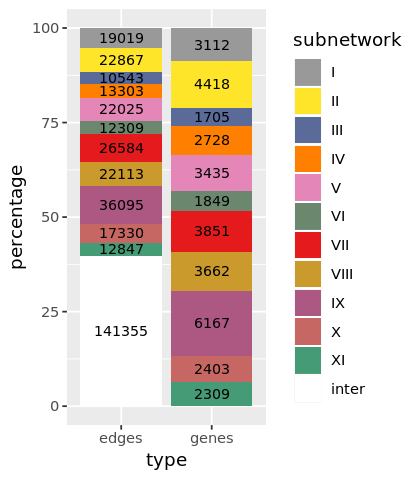

In [39]:
options(repr.plot.width=3.5, repr.plot.height=4)
GG=ggplot(Q,aes(x=type,y=percentage,fill=subnetwork,label=frequency)) +geom_bar(stat="identity",position="stack") + 
scale_fill_manual(values=col3)+#coord_flip() +
   scale_x_discrete(labels = function(x) str_wrap(x, width = 10)) +
  geom_text(size = 3, position = position_stack(vjust = 0.5))
GG
ggsave(GG,file="Fig2.subnetwork.pdf",width=3.5,height=4)

In [40]:
KK=read.delim("Fig2.edges.tsv",sep="\t",stringsAsFactors=FALSE)
head(KK)

regulatoryGene,targetGene,full_cor,full_reg,our_cor,our_reg,weight,regulator_rank,target_rank,mutual_rank,regulator_community,target_community,community
Pp3c1_8530.mRNA,Pp3c13_7860.mRNA,0.6123361,+,0.9439403,+,0.04557562,2,1,1.414214,II,II,II
Pp3c1_32440.mRNA,Pp3c7_20720.mRNA,0.5851975,+,0.6406587,+,0.04301223,10,1,3.162278,II,II,II
Pp3c4_3072.pre_miRNA,Pp3c4_3060.mRNA,0.6451182,+,0.9010807,+,0.04153253,3,1,1.732051,II,II,II
Pp3c17_17550.mRNA,Pp3c13_7860.mRNA,-0.6778203,-,-0.9432600,-,0.04019807,23,2,6.782330,II,II,II
Pp3c17_13620.mRNA,Pp3c7_20720.mRNA,0.7044248,+,0.7631758,+,0.03797029,13,2,5.099020,II,II,II
Pp3c26_6050.mRNA,Pp3c14_6190.mRNA,0.7953527,+,0.9213412,+,0.03750497,1,1,1.000000,X,X,X


regulator,target,directionality,frequency,percentage
II,II,-,514,13.427377
II,II,+,2019,52.742947
II,IX,-,195,2.557042
II,IX,+,400,5.245214
II,V,-,112,2.354425
II,V,+,281,5.907084


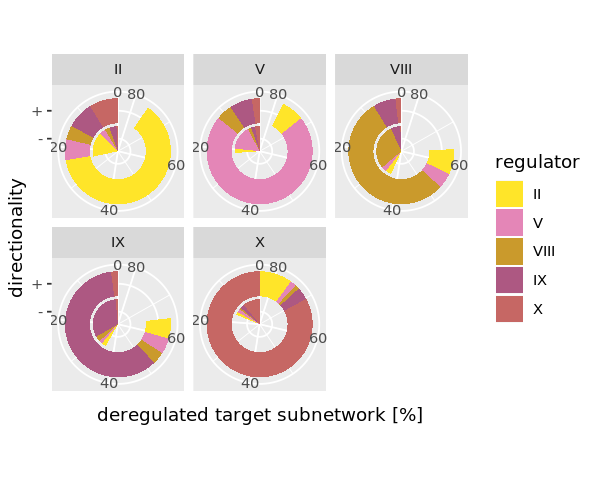

In [54]:
X=data.frame(table(KK$regulator_community,KK$target_community,KK$our_reg))
names(X)=c("regulator","target","directionality","frequency")
XX=data.frame(prop.table(table(KK$regulator_community,KK$target_community,KK$our_reg),2)*100)
names(XX)=c("regulator","target","directionality","percentage")
X=merge(X,XX,by=c("regulator","target","directionality"))
head(X)

X$regulator=ordered(X$regulator,levels=c("II","V","VIII","IX","X"))
X$target=ordered(X$target,levels=c("II","V","VIII","IX","X"))

options(repr.plot.width=5, repr.plot.height=4)
GG=ggplot(X,aes(x=directionality,y=percentage,fill=regulator)) + facet_wrap(~target) +geom_bar(stat="identity",position="stack") + 
   scale_fill_manual(values=col3)+#coord_flip() +
   coord_polar(theta = "y",clip="on",direction=-1) +
   scale_x_discrete(labels = function(x) str_wrap(x, width = 10)) +
   ylab("deregulated target subnetwork [%]")
  #geom_text(size = 1, position = position_stack(vjust = 0.5))
GG
ggsave(GG,file="Fig2.edges.pdf",width=5,height=4)

In [55]:
library(vcd)

png 
  2

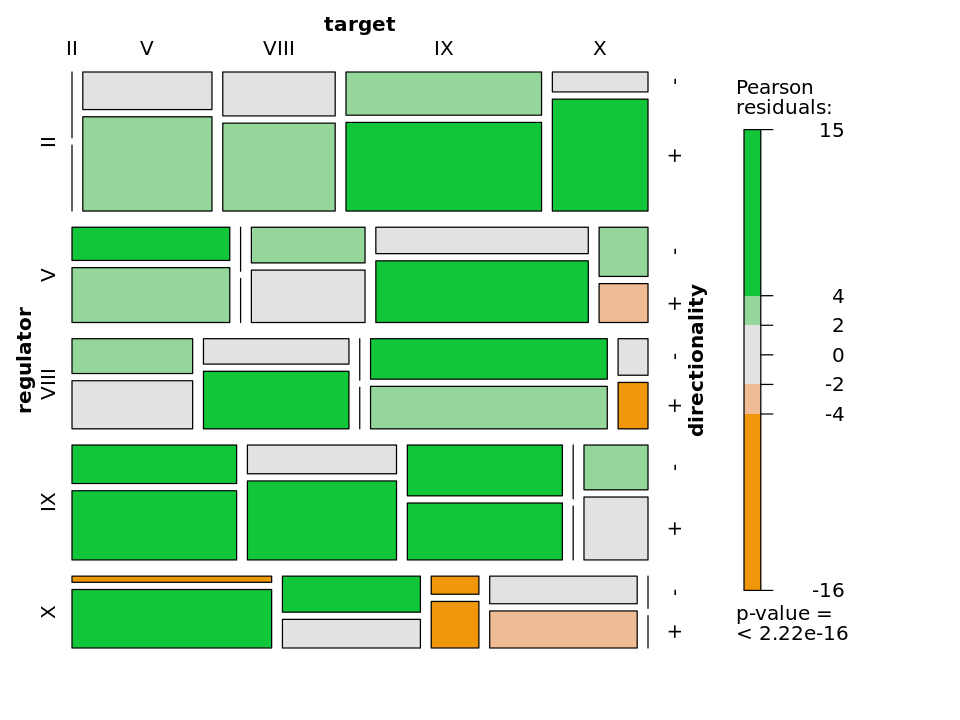

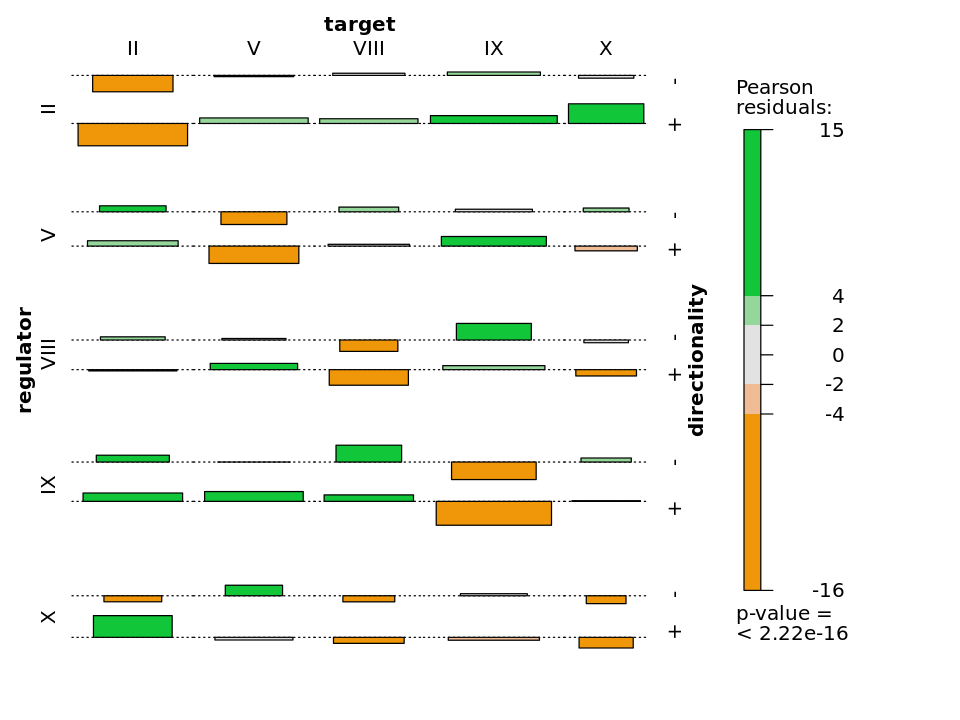

In [56]:
options(repr.plot.width=8, repr.plot.height=6)
#https://cran.r-project.org/web/packages/vcd/vignettes/strucplot.pdf # Pearson  residuals  = standardized deviations  of  observed  from  expected  values
#https://stats.stackexchange.com/questions/266001/how-to-determine-significant-associations-in-a-mosaic-plot
XX=xtabs(frequency~regulator+target+directionality,subset(X,regulator!= target))
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
pdf("mosaic_plot.inter-subnetwork_edges.DEK1_target_enriched_subnetworks.pdf")
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
dev.off()
assoc(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

In [57]:
table(KK$regulator_community,KK$target_community,KK$our_reg)

, ,  = -

      
         II   IX    V VIII    X
  II    514  195  112  114   44
  IX    148 2039  100  184   67
  V     124  133  625   96   57
  VIII  100  228   88  874   26
  X      30   99  121   21  270

, ,  = +

      
         II   IX    V VIII    X
  II   2019  400  281  228  247
  IX    266 3850  275  206   94
  V     205  310 2860  141   45
  VIII  138  239  199 1625   33
  X     284  133   96   54 2041


In [58]:
summary(glm(frequency~0+as.character(regulator)+as.character(target)+directionality, data=subset(X,target!= regulator),family=poisson()))


Call:
glm(formula = frequency ~ 0 + as.character(regulator) + as.character(target) + 
    directionality, family = poisson(), data = subset(X, target != 
    regulator))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.0174  -2.6386  -0.6469   0.9146  10.5654  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
as.character(regulator)II    5.16264    0.04514 114.374  < 2e-16 ***
as.character(regulator)IX    5.06781    0.03991 126.974  < 2e-16 ***
as.character(regulator)V     4.74508    0.04252 111.586  < 2e-16 ***
as.character(regulator)VIII  4.64019    0.04328 107.201  < 2e-16 ***
as.character(regulator)X     4.33053    0.04621  93.719  < 2e-16 ***
as.character(target)IX       0.25940    0.03940   6.584 4.57e-11 ***
as.character(target)V       -0.14144    0.04127  -3.427  0.00061 ***
as.character(target)VIII    -0.36105    0.04316  -8.366  < 2e-16 ***
as.character(target)X       -0.94475    0.05014 -18.842  < 2e-16 ***
directiona

In [143]:
library(gmodels)

In [159]:
KKK=droplevels(subset(KK,community=="0"))
table(KKK$regulator_community,KKK$target_community)

      
        II  IX   V VIII   X
  II     0 595 393  342 291
  IX   414   0 375  390 161
  V    329 443   0  237 102
  VIII 238 467 287    0  59
  X    314 232 217   75   0

In [165]:
CrossTable(KKK$regulator_community,paste(KKK$target_community,KKK$our_reg),
           prop.r=FALSE, prop.c=FALSE,
           prop.t=FALSE, prop.chisq=FALSE, chisq = FALSE, fisher=FALSE, mcnemar=FALSE,
           resid=TRUE, sresid=TRUE, asresid=FALSE,
           missing.include=FALSE,format="SPSS")


   Cell Contents
|-------------------------|
|                   Count |
|                Residual |
|            Std Residual |
|-------------------------|

Total Observations in Table:  5961 

                        | paste(KKK$target_community, KKK$our_reg) 
KKK$regulator_community |     II -  |     II +  |     IX -  |     IX +  |      V -  |      V +  |   VIII -  |   VIII +  |      X -  |      X +  | Row Total | 
------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
                     II |        0  |        0  |      195  |      400  |      112  |      281  |      114  |      228  |       44  |      247  |     1621  | 
                        | -109.318  | -242.837  |   16.883  |  105.767  |   -2.484  |   49.584  |    1.147  |   56.953  |   -8.755  |  133.060  |           | 
                        |  -10.456  |  -15.583  |    1.265  |    6.166  |   -0.232  |    3.259  |    

      
       II - II + IX - IX + V - V + VIII - VIII + X - X +
  II      0    0  195  400 112 281    114    228  44 247
  IX    148  266    0    0 100 275    184    206  67  94
  V     124  205  133  310   0   0     96    141  57  45
  VIII  100  138  228  239  88 199      0      0  26  33
  X      30  284   99  133 121  96     21     54   0   0

      
               II -         II +         IX -         IX +          V -
  II   -10.45550401 -15.58323701   1.26502442   6.16602439  -0.23218471
  IX     6.06264918   4.60594354 -12.13426536 -15.59575732   0.55112963
  V      5.66968080   2.98925282   0.98854653   7.62909811  -8.85805794
  VIII   3.45916097  -1.54985281  10.47004818   3.49187564   1.59854667
  X     -3.52686561  14.14282097   0.72112608  -1.54931584   8.03516572
      
                V +       VIII -       VIII +          X -          X +
  II     3.25945135   0.10799844   4.35473877  -1.20541159  12.46542542
  IX     6.05155842   9.39160109   5.43304125   3.54188175  -0.01946343
  V    -12.59395823   2.12094300   2.19519329   3.46620683  -3.74476211
  VIII   3.99683428  -8.55393302 -10.53093955  -1.40287223  -4.75564228
  X     -2.16077307  -4.88875282  -3.66089603  -5.22231800  -7.67484229

,regulator,target,directionality,weight
2,IX,II,-,6.062649
3,V,II,-,5.669681
7,IX,II,+,4.605944
10,X,II,+,14.142821
14,VIII,IX,-,10.470048
16,II,IX,+,6.166024
18,V,IX,+,7.629098
25,X,V,-,8.035166
27,IX,V,+,6.051558
32,IX,VIII,-,9.391601


png 
  2

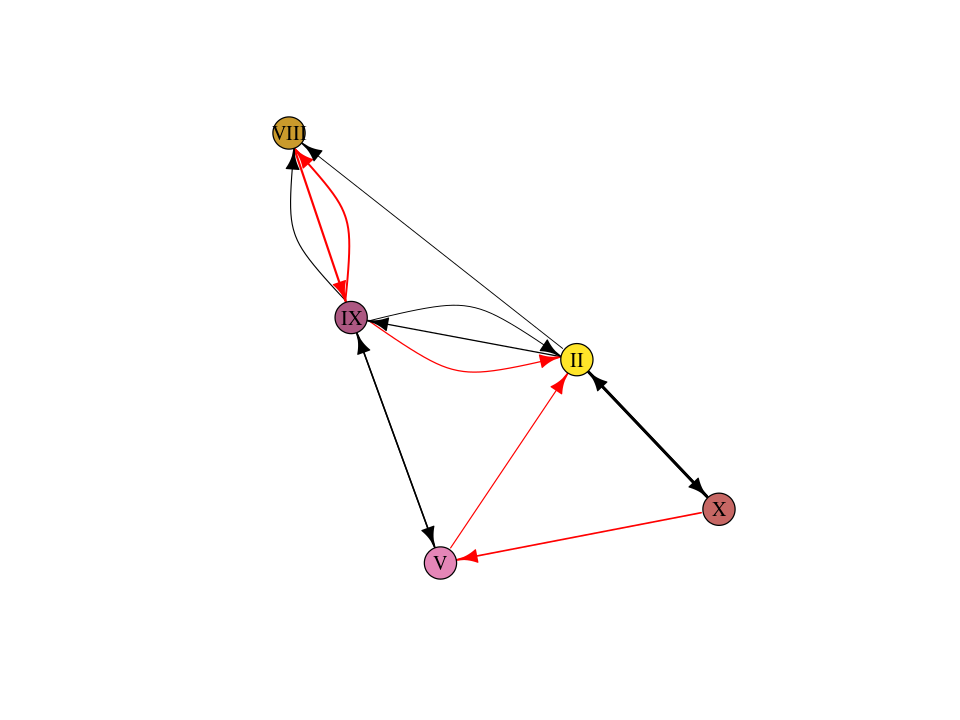

In [228]:
QX=table(KKK$regulator_community,paste(KKK$target_community,KKK$our_reg))
QX
Q=residuals(chisq.test(QX),type="pearson")
Q
Q=data.frame(regulator=rownames(Q)[row(Q)], n=colnames(Q)[col(Q)], weight=c(Q),stringsAsFactors=FALSE)
Q=data.frame(Q,do.call(rbind,strsplit(as.character(Q$n)," ")))
Q=Q[,-2]
Q=Q[,c(1,3,4,2)]
names(Q)=c("regulator","target","directionality","weight")
Q=subset(Q,regulator!=target)
Q=subset(Q,weight>4)
Q

set.seed(27042012)

Gd=graph_from_data_frame(Q,directed = TRUE)

net=Gd
plot.igraph(net,vertex.label=V(net)$name,layout=layout_with_fr, vertex.label.color="black",
            edge.color=ifelse(E(net)$directionality=="+","black","red"),edge.width=E(net)$weight/6, vertex.color=col2[V(net)$name],edge.arrow.size=1,
            )
pdf("DEK1_potential_targets.inter-subnetwork.mosaic_graph.pdf")
plot.igraph(net,vertex.label=V(net)$name,layout=layout_with_fr, vertex.label.color="black",
            edge.color=ifelse(E(net)$directionality=="+","black","red"),edge.width=E(net)$weight/6, vertex.color=col2[V(net)$name],edge.arrow.size=1,
            )
dev.off()

In [46]:
Tc=read.delim("../../sleuth//comp.WT_time_series/dge.tsv.gz",sep="\t",stringsAsFactors=FALSE)
nrow(Tc)
Tc=na.omit(Tc)
nrow(Tc)
Tc=subset(Tc,qval<0.05)
nrow(Tc)
head(Tc)

[1] 39246

[1] 21752

[1] 14939

target_id,class,TYPE,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
Pp3c1_13200.mRNA,mRNA,mRNA,1.323964e-12,2.660770e-08,61.62035,83.64486,4,3.499105,6.434220,0.033297428,6.400922,0.28276158,6.400922
Pp3s49_30.mRNA,mRNA,mRNA,2.446460e-12,2.660770e-08,60.35206,177.52794,4,4.010792,13.655995,0.006823643,13.649171,0.19551171,13.649171
Pp3c27_870.mRNA,mRNA,mRNA,4.003216e-12,2.902599e-08,59.33423,72.68902,4,5.048467,5.591463,0.121885115,5.469578,0.07796317,5.469578
Pp3c23_22550.mRNA,mRNA,mRNA,1.101617e-11,4.146731e-08,57.24022,78.13027,4,2.390192,6.010021,0.012143106,5.997877,0.53132344,5.997877
Pp3c12_9480.mRNA,mRNA,mRNA,1.113520e-11,4.146731e-08,57.21798,77.60833,4,3.240689,5.969872,0.035061400,5.934810,0.33307148,5.934810
Pp3c13_6220.mRNA,mRNA,mRNA,1.171338e-11,4.146731e-08,57.11319,97.44026,4,2.682543,7.495404,0.014080861,7.481324,0.45592527,7.481324


In [47]:
PP=pp
PP[["WT gametophyte development"]]=unique(Tc$target_id)

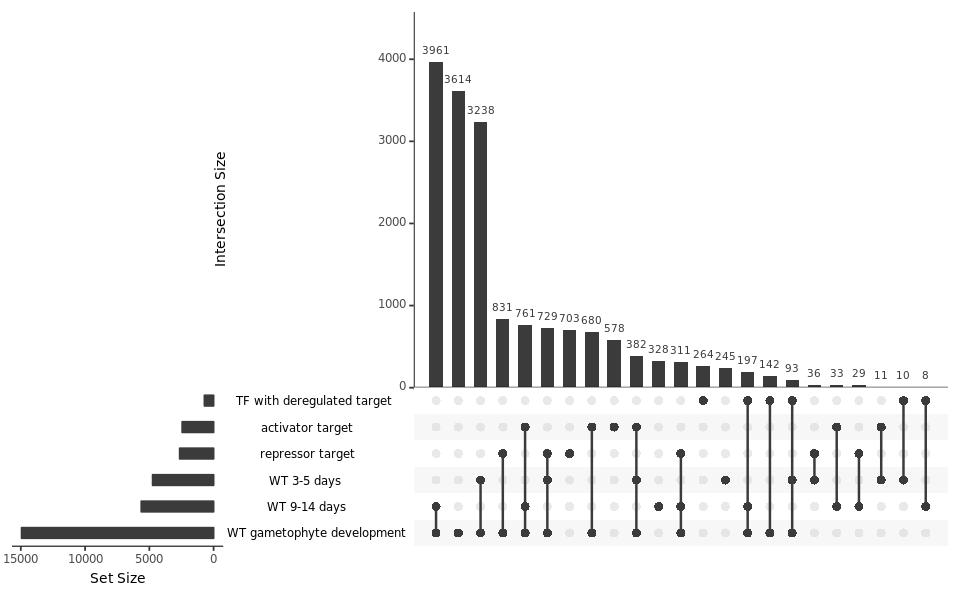

In [48]:
options(repr.plot.width=8, repr.plot.height=5)
u=upset(fromList(PP), order.by = "freq",keep.order = TRUE,nsets=length(names(PP)),nintersects=25,mb.ratio = c(0.65, 0.35))
u

In [49]:
pdf("Intersections.DGE_sets.pdf",width=8,height=5)
u
dev.off()

png 
  2

In [52]:
str(PP)
length(intersect(PP[["repressor target"]],PP[["WT gametophyte development"]]))
length(intersect(PP[["repressor target"]],PP[["WT gametophyte development"]]))/length(PP[["repressor target"]])
length(intersect(PP[["repressor target"]],PP[["WT 3-5 days"]]))
length(intersect(PP[["repressor target"]],PP[["WT 3-5 days"]]))/length(PP[["repressor target"]])
length(intersect(PP[["activator target"]],PP[["WT gametophyte development"]]))
length(intersect(PP[["activator target"]],PP[["WT gametophyte development"]]))/length(PP[["activator target"]])
length(intersect(PP[["activator target"]],PP[["WT 9-14 days"]]))
length(intersect(PP[["activator target"]],PP[["WT 9-14 days"]]))/length(PP[["activator target"]])

List of 6
 $ TF with deregulated target: chr [1:714] "Pp3c1_12940.mRNA" "Pp3c1_14230.mRNA" "Pp3c1_14480.mRNA" "Pp3c1_15290.mRNA" ...
 $ repressor target          : chr [1:2639] "Pp3c1_10200.mRNA" "Pp3c1_10220.mRNA" "Pp3c1_11030.mRNA" "Pp3c1_11190.mRNA" ...
 $ activator target          : chr [1:2445] "Pp3c1_10400.mRNA" "Pp3c1_10760.mRNA" "Pp3c1_10830.mRNA" "Pp3c1_12715.mRNA" ...
 $ WT 3-5 days               : chr [1:4744] "Pp3c18_20030.mRNA" "Pp3c3_31560.mRNA" "Pp3c1_15390.mRNA" "Pp3c16_4180.mRNA" ...
 $ WT 9-14 days              : chr [1:5628] "Pp3s49_30.mRNA" "Pp3c7_9420.mRNA" "Pp3c26_14380.mRNA" "Pp3c14_20550.mRNA" ...
 $ WT gametophyte development: chr [1:14939] "Pp3c1_13200.mRNA" "Pp3s49_30.mRNA" "Pp3c27_870.mRNA" "Pp3c23_22550.mRNA" ...


[1] 1871

[1] 0.7089807

[1] 765

[1] 0.2898825

[1] 1823

[1] 0.7456033

[1] 794

[1] 0.3247444

In [53]:
for (nnn in names(PP)){
    nn=gsub(" ","_",paste0("gene_sets/",nnn,".set"))
    write.table(PP[[nnn]],file=nn,sep="\t",row.names=FALSE,col.names=FALSE)
}